In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
%matplotlib inline

from utils import filter_keylogs,generate_1d_cost_matrix

In [2]:
with open('../keyLog.txt','r') as f:
    key_logs = f.read().splitlines()
data = filter_keylogs(key_logs)

In [3]:
from collections import Counter


keys = [d[1] for d in data]
total_keys = len(set(keys))
key_freqs = Counter(keys)

In [4]:
key_names = [k[0].replace('Key.','') for k in key_freqs.most_common(total_keys)]
key_values = [k[1] for k in key_freqs.most_common(total_keys)]

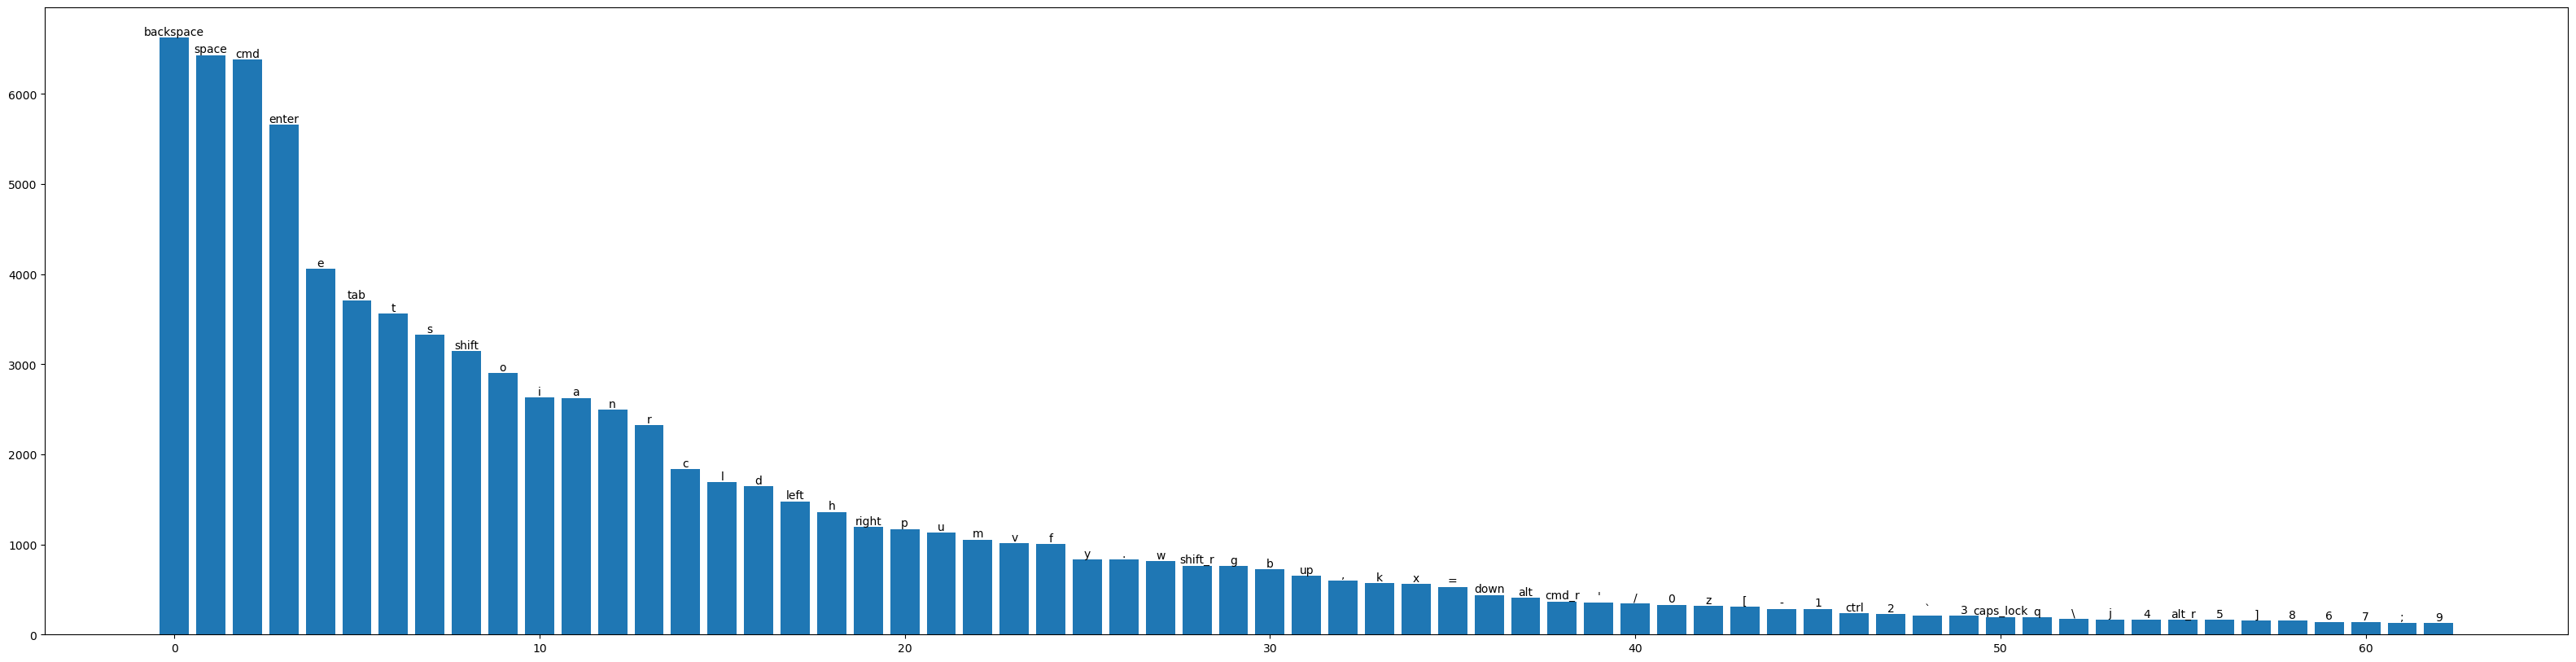

In [5]:
plt.figure(figsize=(40,10))
plt.bar_label(plt.bar(range(total_keys), key_values), key_names);
plt.savefig('key_freqs.png')

In [6]:
# Which keys are most frequently pressed together?

import datetime
from collections import defaultdict

key_pairs = defaultdict(int)
key_counts = defaultdict(int)

for line,next_line in zip(data,data[1:]):
    date,command = line
    next_date,next_command = next_line
    command = command.replace('Key.','')
    next_command = next_command.replace('Key.','')
    time_delta = datetime.datetime.strptime(next_date,'%Y-%m-%d %H:%M:%S,%f') - datetime.datetime.strptime(date,'%Y-%m-%d %H:%M:%S,%f')
    if time_delta.seconds <= 1:
        key_pairs[(command,next_command)] += time_delta.total_seconds()
        key_counts[(command,next_command)] += 1

key_pairs_normalized = {k:v/key_counts[k] for k,v in key_pairs.items()}
key_pairs_sorted = sorted(key_pairs_normalized.items(), key=lambda x: x[1], reverse=True)

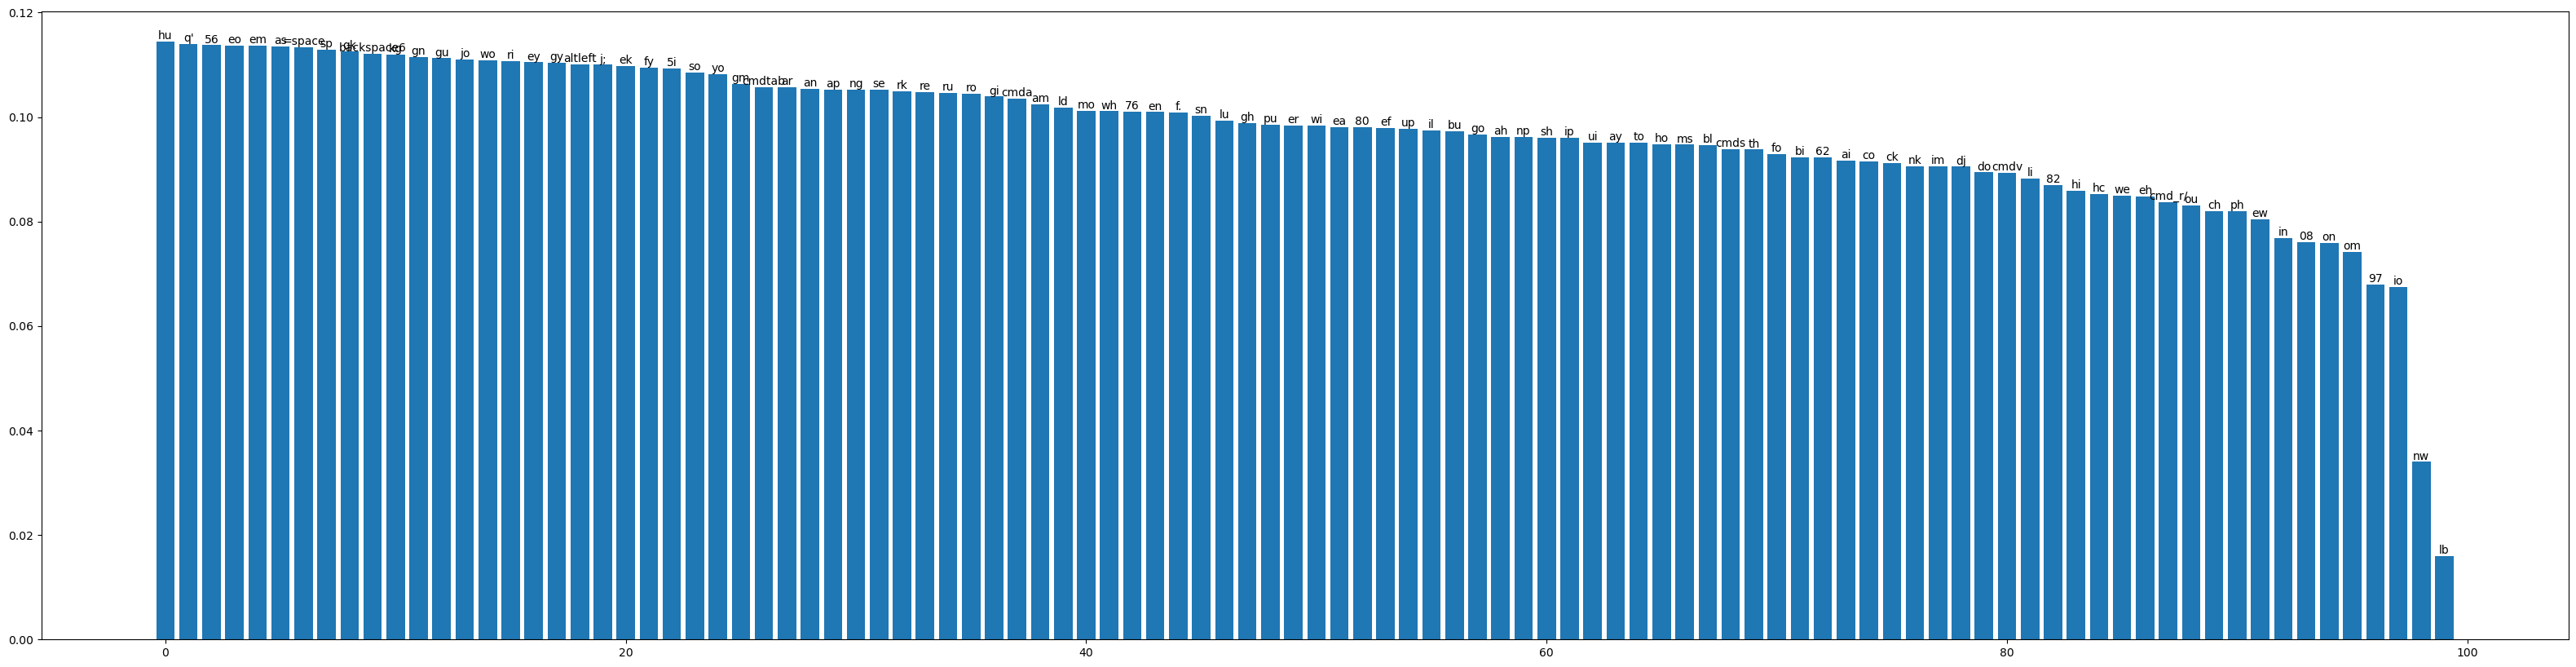

In [7]:
# best 100 key pairs
best_key_pairs = key_pairs_sorted[-100:]
plt.figure(figsize=(40,10))
plt.bar_label(plt.bar(range(len(best_key_pairs)), [v for k,v in best_key_pairs]), [''.join(k) for k,v in best_key_pairs]);
plt.savefig('best_100_key_combos.png')

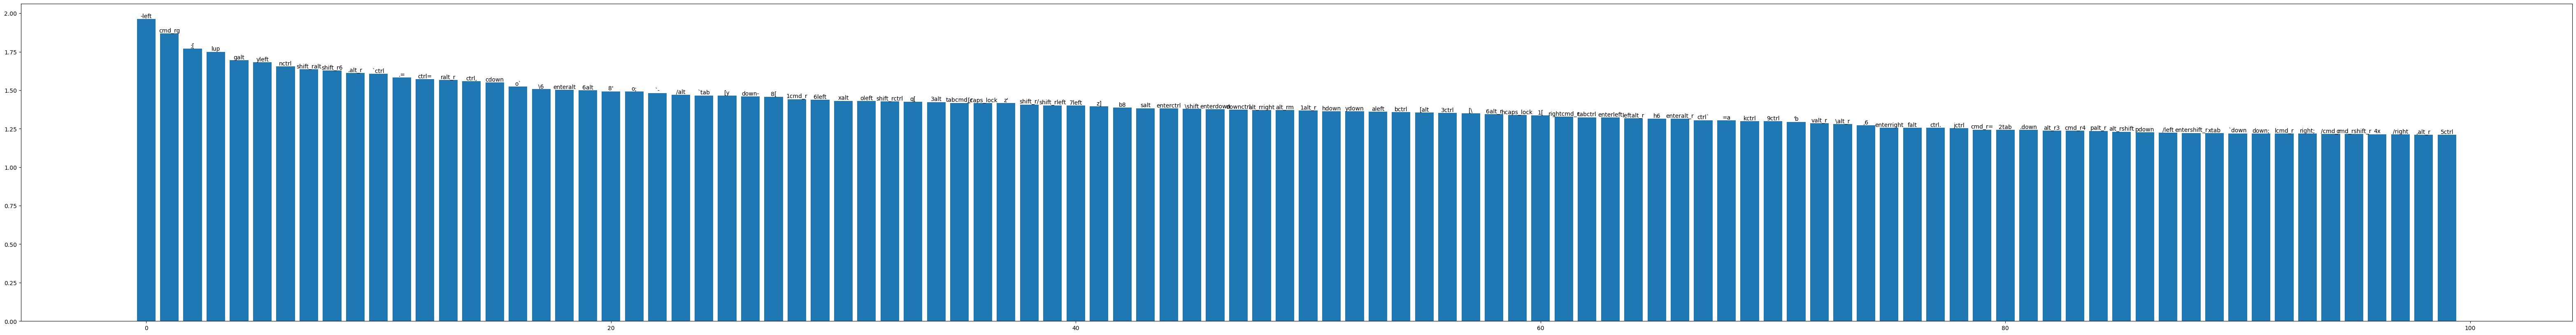

In [8]:
# worst 100 key pairs
worst_key_pairs = key_pairs_sorted[:100]
plt.figure(figsize=(80,10))
plt.bar_label(plt.bar(range(len(worst_key_pairs)), [v for k,v in worst_key_pairs]), [''.join(k) for k,v in worst_key_pairs]);
plt.savefig('worst_100_key_combos.png')

In [9]:
# Which keys are most frequently pressed together?
key_pairs_sorted = sorted(key_counts.items(), key=lambda x: x[1], reverse=True)

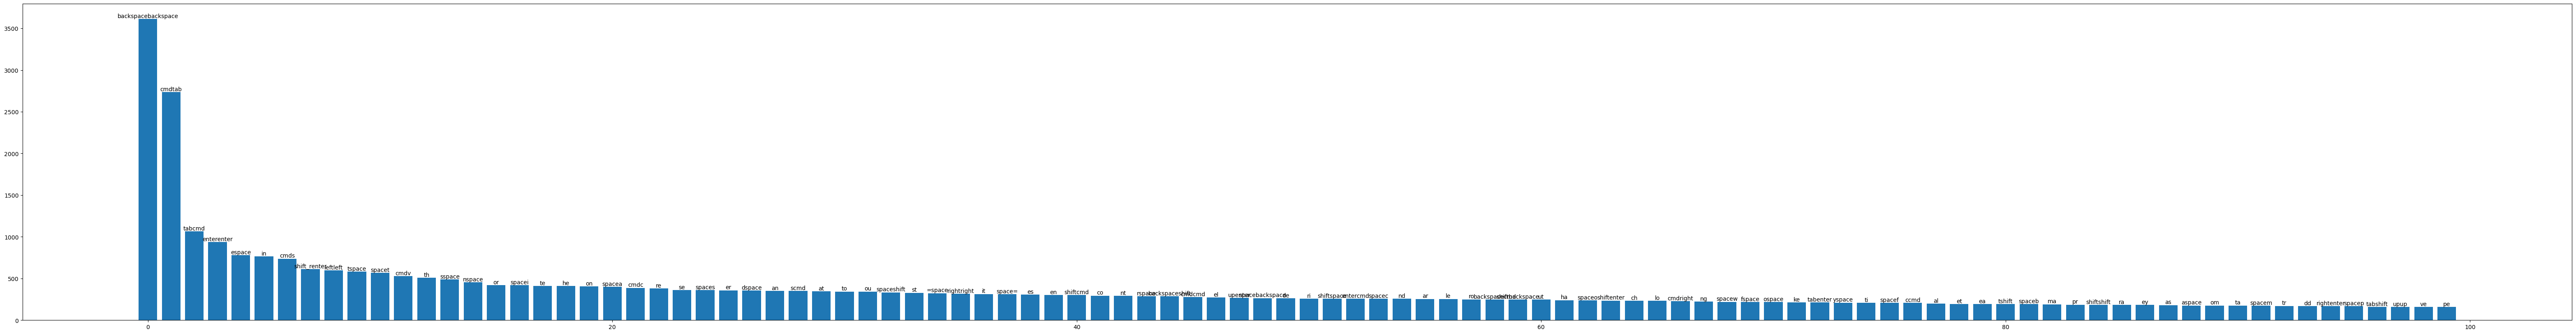

In [10]:
# most frequent 100 key pairs
top_key_pairs = key_pairs_sorted[:100]
plt.figure(figsize=(80,10))
plt.bar_label(plt.bar(range(len(top_key_pairs)), [v for k,v in top_key_pairs]), [''.join(k) for k,v in top_key_pairs]);
plt.savefig('100_most_frequent_key_combos.png')

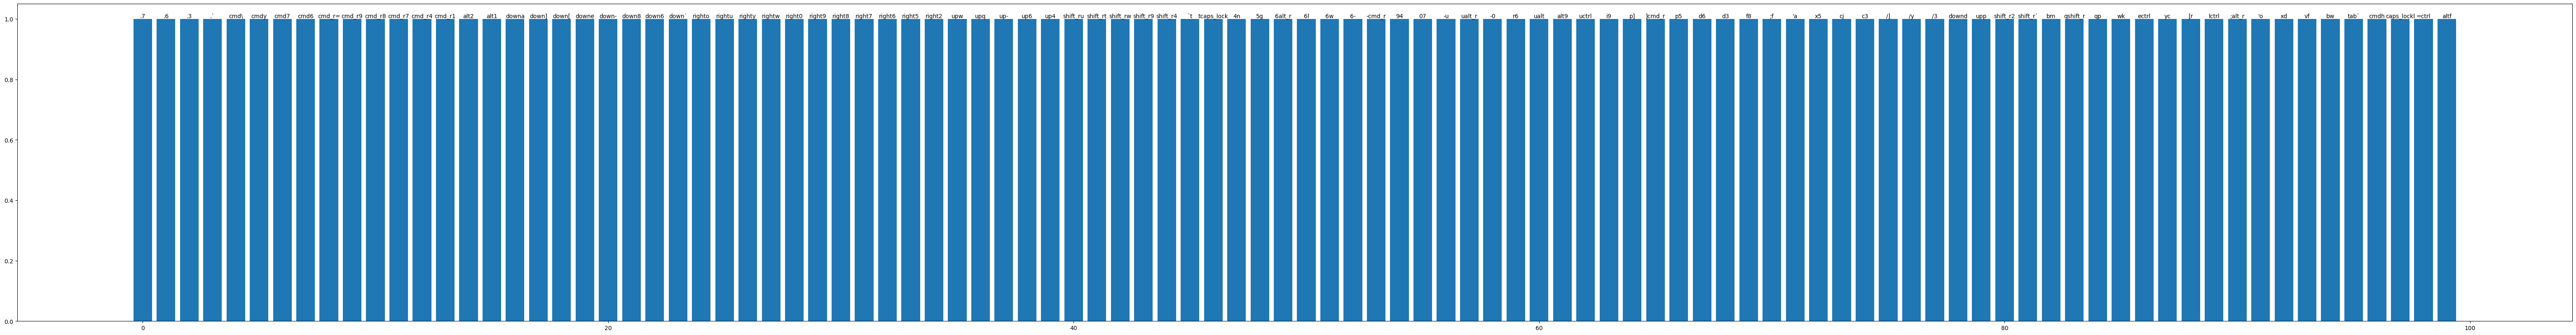

In [11]:
# least frequent 100 key pairs
bot_key_pairs = key_pairs_sorted[-100:]
plt.figure(figsize=(80,10))
plt.bar_label(plt.bar(range(len(bot_key_pairs)), [v for k,v in bot_key_pairs]), [''.join(k) for k,v in bot_key_pairs]);
plt.savefig('100_least_frequent_key_combos.png')

In [12]:
# Train a keyboard on the keylogs

from genetic_algo import GenericKeyboardSearch
from utils import generate_cost_matrix

# Create the dataset from the keylogs
def keylog_dataset():
    keys = []
    for line,next_line in zip(data,data[1:]):
        date,command = line
        next_date,next_command = next_line
        # command = command.replace('Key.','')
        # next_command = next_command.replace('Key.','')
        time_delta = datetime.datetime.strptime(next_date,'%Y-%m-%d %H:%M:%S,%f') - datetime.datetime.strptime(date,'%Y-%m-%d %H:%M:%S,%f')
        if time_delta.seconds <= 1:
            keys.append(next_command)
    return keys

generate_cost_matrix()
cost_matrix = np.load('assets/cost_matrix.npy')
training_data = keylog_dataset()
search = GenericKeyboardSearch(training_data,cost_matrix)

In [ ]:
keyboard = search.run_evolution()

In [26]:
# train a NN to predict the best keyboard
import torch
import torch.nn as nn
import torch.nn.functional as F
from datatypes import CHANGEABLE_KEYS,REMAINING_MODIFIER_KEYS

generate_1d_cost_matrix()
cost_matrix = np.load('assets/cost_matrix_1d.npy')

# we want the nn to output a probability matrix based on the keylogs. the matrix is num_keys by num_keys.
# we sequentially sample the matrix and mask out the choices that have already been made.

torch.manual_seed(0);


# def randomly_permute_keyboard(self):
#     result = np.random.choice(CHANGEABLE_KEYS, size=len(CHANGEABLE_KEYS), replace=False)
#     translation_dictionary = {k:v for k,v in zip(result,CHANGEABLE_KEYS)}
#     translation_dictionary |= {k:v for k,v in zip(REMAINING_MODIFIER_KEYS,REMAINING_MODIFIER_KEYS)}
#     # print('randomly_permute_keyboard',translation_dictionary)
#     return translation_dictionary



/Users/Shuza/Code/keyboard_gen/python/utils.py:81: RuntimeWarning: invalid value encountered in divide
  cost_matrix = cost_matrix / count_matrix


In [30]:

# create a keys by keys matrix of torch probabilities
matrix = torch.rand(len(CHANGEABLE_KEYS),len(CHANGEABLE_KEYS))
probs = F.softmax(matrix,dim=1)
# print(sum(probs[0,:]),sum(probs[:,0]))
# print(matrix[0,:])
# print(probs[0,:])

def get_keyboard_from_probs(probs):
    # probs is a num_keys by num_keys matrix of probabilities
    # we want to sample the matrix and mask out the choices that have already been made.
    # we want to return a keyboard that is a permutation of the CHANGEABLE_KEYS
    result = []
    remaining_keys = list(CHANGEABLE_KEYS)
    for i in range(len(CHANGEABLE_KEYS)):
        key_idx = torch.multinomial(probs[i,:],num_samples=1)
        next_key = remaining_keys[key_idx]
        result.append(next_key)
        probs[:,key_idx] = 0
        probs = probs / probs.sum(dim=1,keepdim=True)


    translation_dictionary = {k:v for k,v in zip(result,CHANGEABLE_KEYS)}
    translation_dictionary |= {k:v for k,v in zip(REMAINING_MODIFIER_KEYS,REMAINING_MODIFIER_KEYS)}
    return translation_dictionary

keyboard = get_keyboard_from_probs(probs)
print(keyboard)

{'5': 'b', '0': "'", 'q': 'Key.tab', 't': '/', 'y': '[', '4': 'Key.space', '2': 'y', '-': 'j', '[': '9', 'f': 'g', 'b': ';', '1': '.', '=': 'u', ';': 'c', 'h': ',', 'd': 'a', 'g': 'Key.backspace', 'c': 'n', "'": 'm', 'Key.enter': 'Key.enter', 'Key.cmd': 'Key.cmd', 'Key.cmd_r': 'Key.cmd_r', 'Key.ctrl': 'Key.ctrl', 'Key.alt': 'Key.alt', 'Key.alt_r': 'Key.alt_r', 'Key.down': 'Key.down', 'Key.left': 'Key.left', 'Key.right': 'Key.right', 'Key.up': 'Key.up', 'Key.shift': 'Key.shift', 'Key.shift_r': 'Key.shift_r', 'Key.caps_lock': 'Key.caps_lock'}


In [52]:
# train a cost function

import einops

n_embd = 100
dropout = 0.1
block_size = 8
n_layer = 4
n_head = 4
vocab_size = total_keys
head_size = n_embd // n_head
n_heads = 4

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



class SelfAttention(nn.Module):
    def __init__(self,head_size):
        super().__init__()
        self.keys = nn.Linear(n_embd,head_size,bias=False)
        self.queries = nn.Linear(n_embd,head_size,bias=False)
        self.values = nn.Linear(n_embd,head_size,bias=False)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('tril',torch.tril(torch.ones((block_size,block_size))))

    # def forward(self,x):
    #     # x.shape = B,T,C
    #     k = self.keys(x)
    #     q = self.queries(x)
    #     v = self.values(x) # B T H
    #     qk = (q @ einops.rearrange(k,'b t c -> b c t')) * head_size**0.5 # (b t t)
    #     kq = (k @ einops.rearrange(q,'b t c -> b c t')) * head_size**0.5 # (b t t)
    #     # print(torch.allclose(qk,kq))
    #     qk = F.softmax(qk,dim=-1) # B T T
    #     print(qk.shape,v.shape)
    #     out = qk @ v
    #     return out

    def forward(self,x):
        # x.shape = B,T,C
        B,T,C = x.shape
        k = self.keys(x)
        q = self.queries(x)
        v = self.values(x)
        qk = (q @ einops.rearrange(k,'b t c -> b c t')) * head_size**0.5 # (b t t)
        qk = qk.masked_fill(self.tril[:T,:T] == 0,float('-inf'))
        qk = F.softmax(qk,dim=-1)
        qk = self.dropout(qk)
        out = qk @ v # (b t c)
        return out

class MultiHeadedAttention(nn.Module):
    def __init__(self,n_heads,head_size):
        super().__init__()
        self.heads = nn.ModuleList([SelfAttention(head_size) for _ in range(n_heads)])
        self.projection = nn.Linear(n_embd,n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self,x):
        out = torch.cat([h(x) for h in self.heads],dim=-1)
        out = self.dropout(self.projection(out))
        return out

class FeedForward(nn.Module):
    def __init__(self,n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd,4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd,n_embd),
            nn.Dropout(dropout)
        )

    def forward(self,x):
        return self.net(x)

# class LayerNorm(nn.Module):
#     def __init__(self,dim, eps=1e-5):
#         self.eps = eps
#         self.gamma = torch.ones(dim)
#         self.beta = torch.zeros(dim)

#     def forward(self,x):
#         xmean = x.mean(1,keepdim=True) # batch mean
#         xvar = x.var(1,keepdim=True) # example variance
#         xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
#         self.out = self.gamma * xhat + self.beta
#         return self.out

class TransformerBlock(nn.Module):
    def __init__(self,n_embd,n_heads):
        super().__init__()
        self.head = MultiHeadedAttention(n_heads,n_embd//n_heads)
        self.ff = FeedForward(n_embd)
        self.layernorm1 = nn.LayerNorm(n_embd)
        self.layernorm2 = nn.LayerNorm(n_embd)

    def forward(self,x):
        x = x + self.head(self.layernorm1(x))
        x = x + self.ff(self.layernorm2(x))
        return x


class KeyboardTime(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding = nn.Embedding(vocab_size,n_embd)
        self.position_embedding = nn.Embedding(block_size,n_embd)
        # self.attn = SelfAttention(n_embd)
        self.tblocks = nn.Sequential(
            *[TransformerBlock(n_embd,n_heads) for _ in range(n_layer)]
            )
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd,vocab_size)

    def forward(self, idx,targets=None):
        B,T = idx.shape
        token_emb = self.token_embedding(idx) # (B,T,C)
        token_emb = token_emb[:,-block_size:,:]
        # print(token_emb.shape)
        pos_emb = self.position_embedding(torch.arange(T,device=device)) # (T,C)
        x = token_emb + pos_emb
        x = self.tblocks(x)
        logits = self.lm_head(x)
        # logits = self.lm_head(token_emb + pos_emb) # (B,T,vocab_size)
        if targets is None: 
            loss = None
        else:
            # logits = einops.rearrange(logits,'b t c -> b c t')
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits,loss

        
    def generate(self,idx,max_new_tokens):
        # idx.shape = (1,8) -> (8,65)
        for _ in range(max_new_tokens):
            idx_cond = idx[:,-block_size:]
            logits,loss = self.forward(idx_cond)
            logits = logits[:,-1,:]
            probs = F.softmax(logits,dim=-1)
            idx_next = torch.multinomial(probs,num_samples=1)
            idx = torch.cat([idx,idx_next],dim=1)
        return idx

In [ ]:
# 